# Freeze Bert Model Using CLS Token
### **Genre Label: 14**
### **Data: Under sampling (max 6000) || clean_df**
### **Bert Model: Uncase**

In [1]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2

In [2]:
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split


# Loading the Dataset and Encoding the Text

# Bert Model

In [5]:
from transformers import BertTokenizer, TFBertModel
import torch

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [6]:
MAX_SEQUENCE_LENGTH = 250

In [7]:
cleaned_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/cleaned_df.pkl')

In [8]:
cleaned_df.head()

,release,danceability,energy,valence,lyrics,broad_genre,track_name,artist_name
24842,2009,0.635,0.746,0.548,"It's a sunny day, so I got nowhere to hide\nNo...",Pop,rain on me,cheryl
16288,1974,0.319,0.925,0.658,Goering's on the phone to Freiburg\nSay's Will...,Rock,me 262,blue öyster cult
9251,2009,0.357,0.708,0.470,Absorbing your words\nBattles raging within me...,Punk,nostalgia,the chameleons
32202,2008,0.617,0.922,0.600,"Well, it's midnight, damn right\nWe're wound u...",Rock,burn it to the ground,nickelback
13271,2012,0.232,0.577,0.669,"Tell me a tale that always was,\nSing me a son...",Rhythm & Blues,tell me a tale,michael kiwanuka


In [9]:
cleaned_df['broad_genre'].value_counts()

,count
broad_genre,
Rock,13399
Pop,13281
Rhythm & Blues,6155
Country,6113
Jazz,4234
Electronic,4079
Metal,3998
Punk,3918
Folk,3223


In [10]:
train_df, remaining_df = train_test_split(cleaned_df, test_size=0.20, random_state=42)
val_df, test_df = train_test_split(remaining_df, test_size=0.50, random_state=42)

print('Training set shape:', train_df.shape)
print('Validation set shape:', val_df.shape)
print('Test set shape:', test_df.shape)

Training set shape: (52240, 8)
Validation set shape: (6530, 8)
Test set shape: (6530, 8)


In [11]:
train_df['broad_genre'].value_counts()

,count
broad_genre,
Rock,10749
Pop,10560
Rhythm & Blues,4917
Country,4915
Jazz,3426
Electronic,3269
Metal,3180
Punk,3145
Folk,2559


In [12]:
# random undersample to fit the lowest class which is alternative
from sklearn.utils import resample

max_samples = 6000
undersampled_train_df = pd.DataFrame()

for genre in train_df['broad_genre'].unique():
    genre_df = train_df[train_df['broad_genre'] == genre]
    if len(genre_df) > max_samples:
        genre_df = resample(genre_df, replace=False, n_samples=max_samples, random_state=42)
    undersampled_train_df = pd.concat([undersampled_train_df, genre_df])

print('Training set genre distribution:')
print(undersampled_train_df['broad_genre'].value_counts())
train_df = undersampled_train_df

Training set genre distribution:
broad_genre
Rock              6000
Pop               6000
Rhythm & Blues    4917
Country           4915
Jazz              3426
Electronic        3269
Metal             3180
Punk              3145
Folk              2559
Hip Hop & Rap     2294
Reggae            2072
Alternative       1154
Name: count, dtype: int64


In [13]:
# getting the text and tables from train, validation and test
train_text = train_df['lyrics'].tolist()
val_text = val_df['lyrics'].tolist()
test_text = test_df['lyrics'].tolist()

train_label = train_df['broad_genre'].tolist()
val_label = val_df['broad_genre'].tolist()
test_label = test_df['broad_genre'].tolist()

In [14]:
# getting rid of \n in the lyrics column
def preprocess_text(text):
  return text.replace('\n', ' ')

train_text = [preprocess_text(text) for text in train_text]
val_text = [preprocess_text(text) for text in val_text]
test_text = [preprocess_text(text) for text in test_text]


In [15]:
encode_label = LabelEncoder()
train_label = encode_label.fit_transform(train_label)
val_label = encode_label.transform(val_label)
test_label = encode_label.transform(test_label)

### Tokenize dataset with expanded genre label

In [16]:
word_len = [len(w.split()) for w in train_text]

sum(word_len) / len(word_len)

178.09193822645642

In [17]:
# training
train_tokenized = bert_tokenizer(train_text,
                                 max_length=MAX_SEQUENCE_LENGTH,
                                 truncation=True,
                                 padding='max_length',
                                 return_tensors='tf')
train_inputs = [train_tokenized.input_ids, train_tokenized.token_type_ids, train_tokenized.attention_mask]
train_labels = np.array(train_label)

# validation
val_tokenized = bert_tokenizer(val_text,
                               max_length=MAX_SEQUENCE_LENGTH,
                               truncation=True,
                               padding='max_length',
                               return_tensors='tf')
val_inputs = [val_tokenized.input_ids, val_tokenized.token_type_ids, val_tokenized.attention_mask]
val_labels = np.array(val_label)

# test
test_tokenized = bert_tokenizer(test_text,
                                max_length=MAX_SEQUENCE_LENGTH,
                                truncation=True,
                                padding='max_length',
                                return_tensors='tf')
test_inputs = [test_tokenized.input_ids, test_tokenized.token_type_ids, test_tokenized.attention_mask]
test_labels = np.array(test_label)

In [18]:
print('Train input IDs shape:', train_inputs[0].shape)
print('Validation input IDs shape:', val_inputs[0].shape)
print('Test input IDs shape:', test_inputs[0].shape)
print('First tokenized train input:', train_inputs[0][0])
print('First tokenized validation input:', val_inputs[0][0])
print('First tokenized test input:', test_inputs[0][0])

Train input IDs shape: (42931, 250)
Validation input IDs shape: (6530, 250)
Test input IDs shape: (6530, 250)
First tokenized train input: tf.Tensor(
[  101  9734  1005  1055  4133  7629  1005  2006  1996  2214  2392  7424
  3422  2378  1005  1996 21868 18082  1996  2598  2045  7110  1005  1056
  1037  2878  2843 17249  1005  2006  3892  1999  2023  2028  3586  2237
  2058 10930 11563  1010  4012  2378  1005  2039  1996  2346  1999  1037
  3786  1011  2039 29009  4744  2014  6898  6838  1010  2002  1005  1055
  3913  2378  1005  2006  1996  7109 17624  2378  1005  2083  1996  8494
  1998  1996 14163  3600  2014  8600  2758  1010  1000  2002  7110  1005
  1056  4276  1037 15385  2043  2009  3310  2000 14332  1010  2002  2288
  1996  2460  2203  1997  1996  6293  1000  2021  9734  1005  1055  2402
  1998  2158  2016  2074  2123  1005  1056  2729  2016  1005  1040  3582
  6838  5973  2016  1005  1055  1999  2293  2007  1996  2879  2016  1005
  1055  1999  2293  2007  1996  2879  2016  100

## Model function

In [19]:
#@title Freeze Bert Classification Model using CLS

def freeze_bert_model_with_CLS(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          num_hidden = 1,
                          dropout=0.3,
                          learning_rate=2e-5,
                          last_layer_num=11,
                          num_classes=14
                       ):
    # freezing all bert layers except the last transformer block
    for w in bert_base_model.weights:
        if f'layer_._{last_layer_num}' not in w.name and 'pooler' not in w.name:
            w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    for i in range(num_hidden - 1):
      hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name=f'hidden_layer_{i+1}')(hidden)
      hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])
    return classification_model

## Models

In [20]:
num_classes = 14
checkpoint_dir = '/content/drive/MyDrive/w266/266 Final Project/model_checkpoints/'
bert_last_layer_num = 11

### 1 Hidden Layer

In [21]:
bert_model_4 = freeze_bert_model_with_CLS(
    bert_model,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=100,
    dropout=0.3,
    learning_rate=2e-5,
    last_layer_num=bert_last_layer_num,
    num_classes = num_classes
)

bert_model_4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 250)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                      

In [22]:
#calculate sample weights
sample_weight = np.ones(shape=(len(train_labels),))
for label in range(np.max(train_labels) + 1):
    class_weight = 1 - np.sum(train_labels == label) / len(train_labels)
    sample_weight[train_labels == label] = class_weight

# setting up check points
checkpoint_prefix = checkpoint_dir + 'bert_weights_%s'
checkpoint_filepath = checkpoint_prefix + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True
)

In [23]:
bert_model_4_history = bert_model_4.fit(
    train_inputs,
    train_labels,
    sample_weight=sample_weight,
    validation_data=(val_inputs, val_labels),
    epochs=3,
    batch_size=8,
    callbacks=[model_checkpoint_callback]
)


Epoch 1/3


5367/5367 [==============================] - 1203s 220ms/step - loss: 1.7169 - accuracy: 0.3182 - val_loss: 1.7028 - val_accuracy: 0.3749
Epoch 2/3
5367/5367 [==============================] - 1167s 218ms/step - loss: 1.5530 - accuracy: 0.3797 - val_loss: 1.6377 - val_accuracy: 0.4057
Epoch 3/3
5367/5367 [==============================] - 1167s 217ms/step - loss: 1.4903 - accuracy: 0.4055 - val_loss: 1.6041 - val_accuracy: 0.4173


In [24]:
val_predictions = bert_model_4.predict(val_inputs)
val_predictions = np.argmax(val_predictions, axis=1)
print(classification_report(val_labels, val_predictions, target_names=encode_label.classes_))


205/205 [==============================] - 123s 585ms/step
                precision    recall  f1-score   support

   Alternative       0.00      0.00      0.00       156
       Country       0.42      0.59      0.49       594
    Electronic       0.31      0.28      0.29       384
          Folk       0.39      0.34      0.36       340
 Hip Hop & Rap       0.71      0.74      0.72       284
          Jazz       0.31      0.41      0.35       398
         Metal       0.58      0.71      0.63       402
           Pop       0.48      0.33      0.39      1328
          Punk       0.33      0.39      0.36       405
        Reggae       0.46      0.38      0.42       284
Rhythm & Blues       0.31      0.34      0.32       631
          Rock       0.40      0.43      0.42      1324

      accuracy                           0.42      6530
     macro avg       0.39      0.41      0.40      6530
  weighted avg       0.41      0.42      0.41      6530



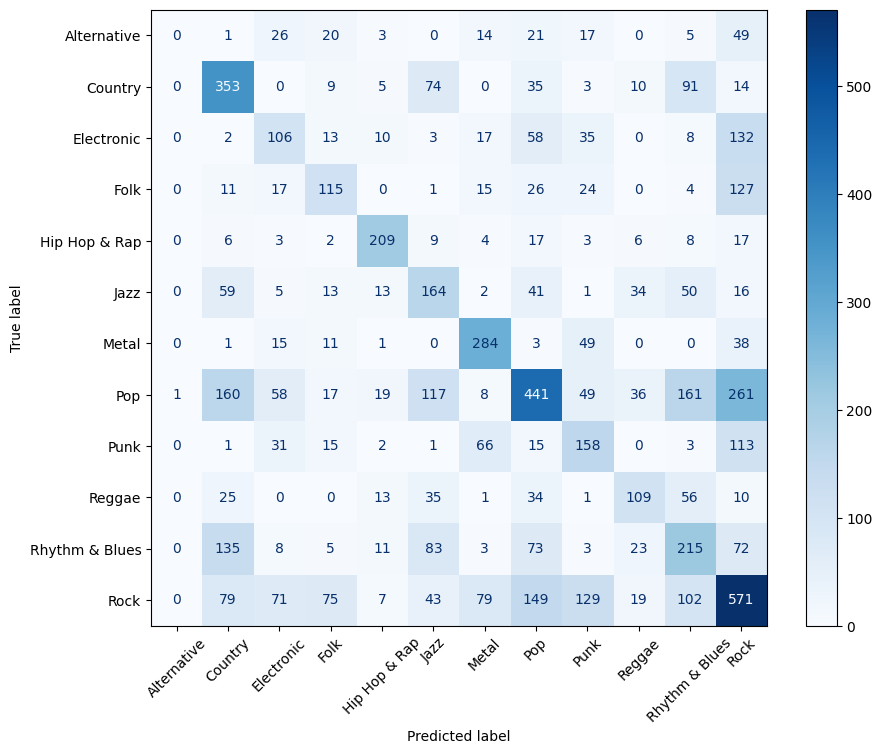

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(val_labels, val_predictions)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encode_label.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.xticks(rotation=45)
plt.show()

### 2 Hidden Layers

In [32]:
bert_model_2 = freeze_bert_model_with_CLS(
    bert_model,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=100,
    num_hidden=2,
    dropout=0.3,
    learning_rate=2e-5,
    last_layer_num=bert_last_layer_num,
    num_classes = num_classes
)

bert_model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 250)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                    

In [ ]:
#calculate sample weights
sample_weight = np.ones(shape=(len(train_labels),))
for label in range(np.max(train_labels) + 1):
    class_weight = 1 - np.sum(train_labels == label) / len(train_labels)
    sample_weight[train_labels == label] = class_weight

# setting up check points
checkpoint_prefix = checkpoint_dir + 'bert_weights_%s'
checkpoint_filepath = checkpoint_prefix + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True
)

In [33]:
bert_model_2_history = bert_model_2.fit(
    train_inputs,
    train_labels,
    sample_weight=sample_weight,
    validation_data=(val_inputs, val_labels),
    epochs=5,
    batch_size=32,
    callbacks=[model_checkpoint_callback]
)


Epoch 1/5


1633/1633 [==============================] - 1308s 791ms/step - loss: 1.7638 - accuracy: 0.3138 - val_loss: 1.6648 - val_accuracy: 0.4139
Epoch 2/5
1633/1633 [==============================] - 1291s 791ms/step - loss: 1.5722 - accuracy: 0.3754 - val_loss: 1.6257 - val_accuracy: 0.4221
Epoch 3/5
1633/1633 [==============================] - 1270s 778ms/step - loss: 1.5128 - accuracy: 0.3934 - val_loss: 1.5835 - val_accuracy: 0.4369
Epoch 4/5
1633/1633 [==============================] - 1295s 793ms/step - loss: 1.4725 - accuracy: 0.4066 - val_loss: 1.5739 - val_accuracy: 0.4320
Epoch 5/5
1633/1633 [==============================] - 1276s 781ms/step - loss: 1.4432 - accuracy: 0.4179 - val_loss: 1.5602 - val_accuracy: 0.4406


In [34]:
val_predictions = bert_model_2.predict(val_inputs)
val_predictions = np.argmax(val_predictions, axis=1)
print(classification_report(val_labels, val_predictions, target_names=encode_label.classes_))


205/205 [==============================] - 125s 582ms/step
                precision    recall  f1-score   support

   Alternative       0.00      0.00      0.00       156
       Country       0.42      0.64      0.51       594
    Electronic       0.36      0.24      0.29       384
          Folk       0.42      0.28      0.34       340
 Hip Hop & Rap       0.83      0.73      0.78       284
          Jazz       0.36      0.38      0.37       398
         Metal       0.62      0.65      0.63       402
           Pop       0.44      0.49      0.47      1328
          Punk       0.39      0.30      0.34       405
        Reggae       0.49      0.42      0.45       284
Rhythm & Blues       0.38      0.20      0.26       631
          Rock       0.40      0.50      0.44      1324

      accuracy                           0.44      6530
     macro avg       0.43      0.40      0.41      6530
  weighted avg       0.43      0.44      0.43      6530



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


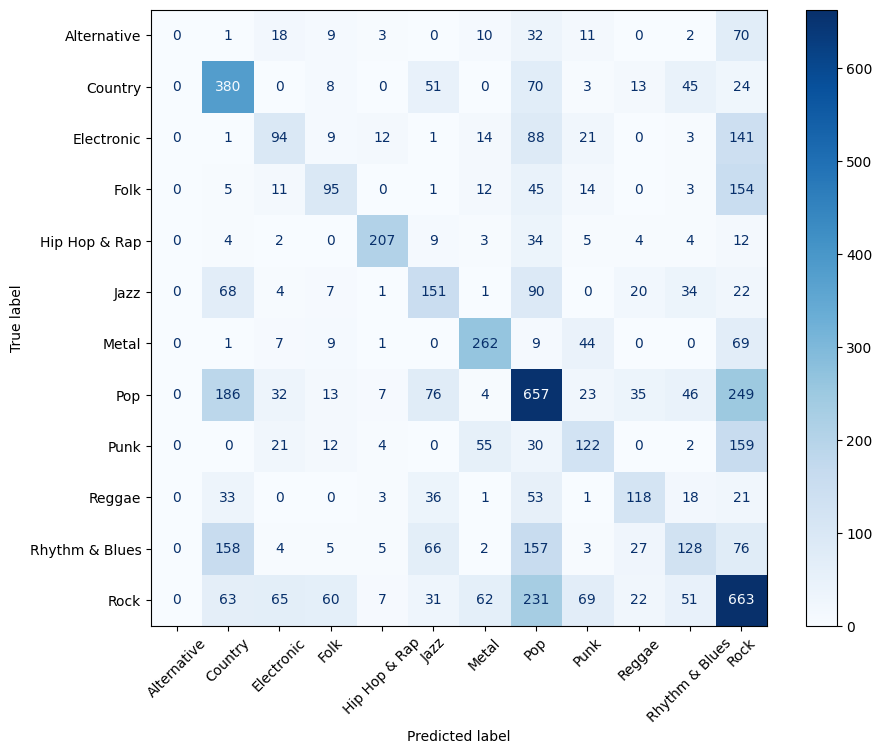

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(val_labels, val_predictions)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encode_label.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.xticks(rotation=45)
plt.show()

## Hypertune Bert Model

In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00


In [ ]:
import optuna
from transformers import BertConfig, TFBertModel

In [ ]:
from transformers import BertConfig, TFBertModel
# function to create custom configuration for bert model to have attention head, intermediate/feed forward layer, dropout probability and attention drop out probability

def get_custom_bert_config(num_attention_heads=4):
    return BertConfig(
        hidden_size=768,
        num_hidden_layers=12,
        num_attention_heads=num_attention_heads,
        intermediate_size=3072,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
    )

In [ ]:

def freeze_bert_model_update(bert_base_model,
                             max_sequence_length=250,
                             hidden_size=150,
                             dropout=0.3,
                             learning_rate=2e-5,
                             last_layer_num=11,
                             num_classes=14):
    for w in bert_base_model.weights:
        if f'layer_._{last_layer_num}' not in w.name and 'pooler' not in w.name:
            w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])
    return classification_model


In [ ]:
def objective(trial):
    num_attention_heads = trial.suggest_categorical('num_attention_heads', [8, 12, 16])
    hidden_size = trial.suggest_int('hidden_size', 100, 300)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
    last_layer_num = trial.suggest_int('last_layer_num', 8, 11)

    custom_config = get_custom_bert_config(num_attention_heads=num_attention_heads)
    bert_base_model = TFBertModel.from_pretrained('bert-base-uncased', config=custom_config)
    model = freeze_bert_model_update(bert_base_model,
                                     hidden_size=hidden_size,
                                     dropout=dropout,
                                     learning_rate=learning_rate,
                                     last_layer_num=last_layer_num,
                                     num_classes=14)

    bert_model_4_history_update = model.fit(
    train_inputs,
    train_labels,
    sample_weight=sample_weight,
    validation_data=(val_inputs, val_labels),
    epochs=3,
    #batch_size=8,
    callbacks=[model_checkpoint_callback]
)

    val_loss = bert_model_4_history_update.history['val_loss'][-1]
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-07-31 18:46:47,619] A new study created in memory with name: no-name-a15fc63e-4c1e-475e-ade8-ca76698dfc77
<ipython-input-48-6728cd828793>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassific

Epoch 1/3


1633/1633 [==============================] - 1641s 997ms/step - loss: 1.7964 - accuracy: 0.2701 - val_loss: 1.7465 - val_accuracy: 0.3553
Epoch 2/3
1633/1633 [==============================] - 1619s 991ms/step - loss: 1.6107 - accuracy: 0.3317 - val_loss: 1.6871 - val_accuracy: 0.3744
Epoch 3/3
1633/1633 [==============================] - 1612s 987ms/step - loss: 1.5542 - accuracy: 0.3564 - val_loss: 1.6473 - val_accuracy: 0.3919


[I 2024-07-31 20:08:23,213] Trial 0 finished with value: 1.647265076637268 and parameters: {'num_attention_heads': 16, 'hidden_size': 198, 'dropout': 0.4267097230134075, 'learning_rate': 1.3223770870969917e-05, 'last_layer_num': 9}. Best is trial 0 with value: 1.647265076637268.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task t

Epoch 1/3


1633/1633 [==============================] - 1616s 983ms/step - loss: 1.6793 - accuracy: 0.3145 - val_loss: 1.6865 - val_accuracy: 0.3796
Epoch 2/3
1633/1633 [==============================] - 1605s 983ms/step - loss: 1.4988 - accuracy: 0.3772 - val_loss: 1.6156 - val_accuracy: 0.4078
Epoch 3/3
1633/1633 [==============================] - 1588s 973ms/step - loss: 1.4442 - accuracy: 0.4020 - val_loss: 1.5854 - val_accuracy: 0.4185


[I 2024-07-31 21:28:58,256] Trial 1 finished with value: 1.5853526592254639 and parameters: {'num_attention_heads': 8, 'hidden_size': 117, 'dropout': 0.10600575173104927, 'learning_rate': 1.8589121297857898e-05, 'last_layer_num': 8}. Best is trial 1 with value: 1.5853526592254639.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task

Epoch 1/3


1633/1633 [==============================] - 1522s 926ms/step - loss: 1.6426 - accuracy: 0.3220 - val_loss: 1.6494 - val_accuracy: 0.3928
Epoch 2/3
1633/1633 [==============================] - 1536s 941ms/step - loss: 1.4855 - accuracy: 0.3851 - val_loss: 1.6015 - val_accuracy: 0.4161
Epoch 3/3
1633/1633 [==============================] - 1534s 939ms/step - loss: 1.4323 - accuracy: 0.4072 - val_loss: 1.5711 - val_accuracy: 0.4219


[I 2024-07-31 22:46:33,085] Trial 2 finished with value: 1.5710983276367188 and parameters: {'num_attention_heads': 16, 'hidden_size': 152, 'dropout': 0.31250699594418585, 'learning_rate': 4.636058714406125e-05, 'last_layer_num': 10}. Best is trial 2 with value: 1.5710983276367188.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the tas

Epoch 1/3


1633/1633 [==============================] - 1698s 1s/step - loss: 1.6003 - accuracy: 0.3403 - val_loss: 1.6213 - val_accuracy: 0.4046
Epoch 2/3
1633/1633 [==============================] - 1669s 1s/step - loss: 1.4297 - accuracy: 0.4056 - val_loss: 1.5779 - val_accuracy: 0.4257
Epoch 3/3
1633/1633 [==============================] - 1659s 1s/step - loss: 1.3773 - accuracy: 0.4335 - val_loss: 1.5659 - val_accuracy: 0.4352


[I 2024-08-01 00:11:08,368] Trial 3 finished with value: 1.5659422874450684 and parameters: {'num_attention_heads': 12, 'hidden_size': 287, 'dropout': 0.11268600944516348, 'learning_rate': 2.5453884030918373e-05, 'last_layer_num': 8}. Best is trial 3 with value: 1.5659422874450684.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the tas

Epoch 1/3
